In [100]:
## general
import numpy as np
import datetime
import joblib
import copy
import xarray as xr
import os
import sys
import datetime as dt
import matplotlib as mpl
import math
import geopandas
import regionmask
import pandas as pd

## statistics
from scipy import stats
from scipy.stats import linregress

## plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import mplotutils as mpu



In [2]:
def linregress_grid(df,df_time,start,end):
    x,y=np.meshgrid(np.arange(72),np.arange(144))
    frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)
    slope=np.zeros([72,144])
    i_start=np.where(df_time==start)[0][0]
    i_end=np.where(df_time==end)[0][0]
    
    for i_x, i_y in zip(x.flatten(),y.flatten()):
        slope[i_x,i_y]=10*stats.linregress(np.arange(end-start),df[i_start:i_end,i_x,i_y])[0]
    return slope

In [107]:
def linregress_grid_var(dfx,dfy,df_time,start,end):
    x,y=np.meshgrid(np.arange(72),np.arange(144))
    slope=np.zeros([72,144])
    i_start=np.where(df_time==start)[0][0]
    i_end=np.where(df_time==end)[0][0]
    
    for i_x, i_y in zip(x.flatten(),y.flatten()):
        slope[i_x,i_y]=10*stats.linregress(dfx[i_start:i_end,i_x,i_y],dfy[i_start:i_end,i_x,i_y])[0]
    return slope

In [3]:
# load the land mask as frac_l
dir_in_geo_dist = '/home/tristan/mesmer/data/'
frac_l = xr.open_mfdataset(dir_in_geo_dist + 'interim_invariant_lsmask_regrid.nc', combine='by_coords',decode_times=False)

frac_l_raw = np.squeeze(copy.deepcopy(frac_l.lsm.values))  #land-sea mask of ERA-interim bilinearily interpolated 

frac_l = frac_l.where(frac_l.lat>-60,0)  # remove Antarctica from frac_l field (ie set frac l to 0)

idx_l=np.squeeze(frac_l.lsm.values)>0.0 # idx_l = index land -> idex land #-> everything >0 we consider as land

lon_pc, lat_pc = mpu.infer_interval_breaks(frac_l.lon, frac_l.lat)  ## is this needed??

In [57]:
frac_l

<xarray.Dataset>
Dimensions:  (time: 1, lat: 72, lon: 144)
Coordinates:
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * lat      (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * time     (time) float64 7.802e+05
Data variables:
    lsm      (time, lat, lon) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu Mar 29 11:40:27 2018: cdo remapbil,mygrid interim_invar...
    CDO:          Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/...

In [147]:
dir_in_data_mod = '/home/tristan/mesmer/data/'

# prepare the inputs as array
BEST_data = 'obs_data_25.nc'
data_mask = 'interim_invariant_lsmask_regrid.nc'       

df_BEST = xr.open_mfdataset(dir_in_data_mod+BEST_data).roll(lon=72).groupby('time.year').mean('time')
df_BEST = df_BEST.where(idx_l == 1)
df_BEST

<xarray.Dataset>
Dimensions:      (year: 172, lat: 72, lon: 144, month_number: 12)
Coordinates:
  * lon          (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat          (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * year         (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021
Dimensions without coordinates: month_number
Data variables:
    land_mask    (year, lat, lon) float64 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    temperature  (year, lat, lon) float32 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>
    climatology  (year, month_number, lat, lon) float32 dask.array<chunksize=(1, 12, 72, 144), meta=np.ndarray>

In [75]:
trend_2010 = {}

for ref in [1951]:
    trend_2010[ref]=linregress_grid(df_BEST.sel(year=slice(1870,2021)).temperature.values,
                                         df_BEST.sel(year=slice(1870,2021)).year.values,ref,2010)
    

/tmp/ipykernel_336/1742338526.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno_r").copy()
  cmap_mesh.set_bad('gray')


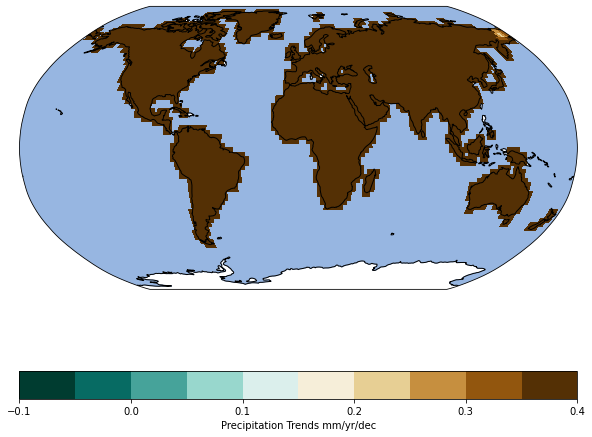

In [166]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))

cmap = plt.cm.get_cmap('BrBG_r',10)

cmap_mesh.set_bad('gray')
mesh_1.set_cmap(cmap_mesh)
cmap_mesh=mesh_1.get_cmap()
mesh_1=ax.pcolormesh(lon_pc, lat_pc, trend_2010[ref], cmap=cmap,vmin=-0.1,vmax=0.4, transform=ccrs.PlateCarree(),rasterized=True)

ax.coastlines()
ax.add_feature(cfeature.OCEAN)
plt.colorbar(mesh_1,orientation='horizontal',label='Precipitation Trends mm/yr/dec')
plt.show()

## Now try annual vs monthly for Jan

In [211]:
dir_in_data_mod = '/home/tristan/mesmer/data/'

# prepare the inputs as array
BEST_data = 'obs_data_25.nc'
data_mask = 'interim_invariant_lsmask_regrid.nc'       
time = pd.date_range(start='1850-01-01', end='2021-12-31', freq='MS') #create time steps

df_jan = xr.open_mfdataset(dir_in_data_mod+BEST_data).roll(lon=72) # load in data
df_jan['time'] = time # fix timesteps in data
df_jan = df_jan.where(df_jan.time.dt.month.isin([1]), drop=True).groupby('time.year').mean('time') # select only January

df_jan = df_jan.where(idx_l == 1)

In [212]:
df_BEST = xr.open_mfdataset(dir_in_data_mod+BEST_data).roll(lon=72).groupby('time.year').mean('time')
df_BEST = df_BEST.where(idx_l == 1)

In [213]:
### using variant of the linregress_grid function, to calculate the linear regression annual vs monthly for Jan

trend_2010 = {}
trend_2020 = {}

for ref in [1951]:
    trend_2010[ref]=linregress_grid_var(df_jan.sel(year=slice(1870,2021)).temperature.values,
                                        df_BEST.sel(year=slice(1870,2021)).temperature.values,
                                         df_BEST.sel(year=slice(1870,2021)).year.values,ref,2010)

    
    trend_2020[ref]=linregress_grid_var(df_jan.sel(year=slice(1870,2021)).temperature.values,
                                        df_BEST.sel(year=slice(1870,2021)).temperature.values,
                                         df_BEST.sel(year=slice(1870,2021)).year.values,ref,2020)
    
print('Valid gridpoints in trend_2010: ', np.count_nonzero(~np.isnan(trend_2010[1951])), '| ',
     'Valid gridpoints in trend_2020: ', np.count_nonzero(~np.isnan(trend_2020[1951])))   ## check that the correct number of gridpoints are not NaN
    

Valid gridpoints in trend_2010:  3043 |  Valid gridpoints in trend_2020:  3043


In [214]:
x = trend_2010[1951][~np.isnan(trend_2010[1951])]
print('min: ', x.min(),'max: ',  x.max())

min:  0.24994143803172053 max:  8.325045996856783


In [215]:
x = trend_2020[1951][~np.isnan(trend_2010[1951])]
print('min: ', x.min(),'max: ',  x.max())

min:  0.41439340206763686 max:  8.70108368017461


In [216]:
### set plot params

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
          'figure.figsize': (9,5),
          "font.family": "serif",
         'ytick.labelsize':'x-large',
         "font.weight":"normal",
         "axes.labelweight":"normal"}
plt.rcParams.update(params)

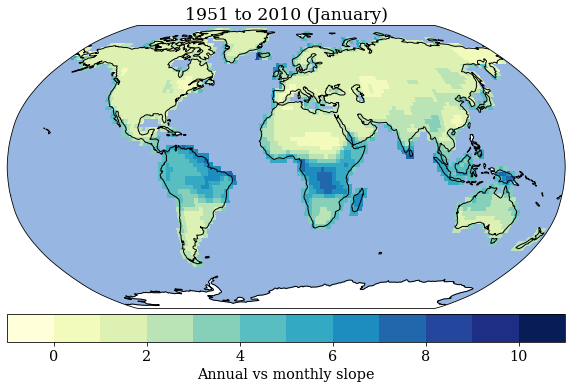

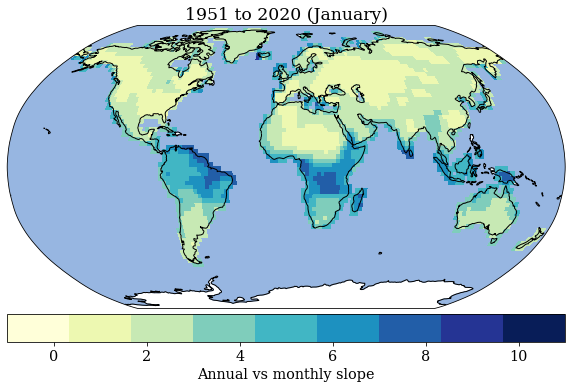

In [222]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
ax.set_title("1951 to 2010 (January)")
cmap = plt.cm.get_cmap('YlGnBu',12)
mesh_1=ax.pcolormesh(lon_pc, lat_pc, trend_2010[ref], cmap=cmap,vmin=-1.0,vmax=11, transform=ccrs.PlateCarree(),rasterized=True)
ax.coastlines()
ax.add_feature(cfeature.OCEAN)
plt.colorbar(mesh_1,orientation='horizontal',label='Annual vs monthly slope', pad=0.01)
plt.show()


fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
ax.set_title("1951 to 2020 (January)")
cmap = plt.cm.get_cmap('YlGnBu',9)
mesh_1=ax.pcolormesh(lon_pc, lat_pc, trend_2020[ref], cmap=cmap,vmin=-1.0,vmax=11, transform=ccrs.PlateCarree(),rasterized=True)
ax.coastlines()
ax.add_feature(cfeature.OCEAN)
plt.colorbar(mesh_1,orientation='horizontal',label='Annual vs monthly slope', pad=0.01)
plt.show()

## Now do for June

In [203]:
dir_in_data_mod = '/home/tristan/mesmer/data/'

# prepare the inputs as array
BEST_data = 'obs_data_25.nc'
data_mask = 'interim_invariant_lsmask_regrid.nc'       
time = pd.date_range(start='1850-01-01', end='2021-12-31', freq='MS') #create time steps

df_jun = xr.open_mfdataset(dir_in_data_mod+BEST_data).roll(lon=72) # load in data
df_jun['time'] = time # fix timesteps in data
df_jun = df_jun.where(df_jun.time.dt.month.isin([6]), drop=True).groupby('time.year').mean('time') # select only January

df_jun = df_jun.where(idx_l == 1)

In [204]:
df_BEST = xr.open_mfdataset(dir_in_data_mod+BEST_data).roll(lon=72).groupby('time.year').mean('time')
df_BEST = df_BEST.where(idx_l == 1)

In [205]:
### using variant of the linregress_grid function, to calculate the linear regression annual vs monthly for Jan

trend_2010 = {}
trend_2020 = {}

for ref in [1951]:
    trend_2010[ref]=linregress_grid_var(df_jun.sel(year=slice(1870,2021)).temperature.values,
                                        df_BEST.sel(year=slice(1870,2021)).temperature.values,
                                         df_BEST.sel(year=slice(1870,2021)).year.values,ref,2010)

    
    trend_2020[ref]=linregress_grid_var(df_jun.sel(year=slice(1870,2021)).temperature.values,
                                        df_BEST.sel(year=slice(1870,2021)).temperature.values,
                                         df_BEST.sel(year=slice(1870,2021)).year.values,ref,2020)
    
print('Valid gridpoints in trend_2010: ', np.count_nonzero(~np.isnan(trend_2010[1951])), '| ',
     'Valid gridpoints in trend_2020: ', np.count_nonzero(~np.isnan(trend_2020[1951])))   ## check that the correct number of gridpoints are not NaN
    

Valid gridpoints in trend_2010:  3043 |  Valid gridpoints in trend_2020:  3043


In [206]:
x = trend_2010[1951][~np.isnan(trend_2010[1951])]
print('min: ', x.min(),'max: ',  x.max())

min:  -0.49242389591910096 max:  8.90821218656977


In [207]:
x = trend_2020[1951][~np.isnan(trend_2010[1951])]
print('min: ', x.min(),'max: ',  x.max())

min:  0.26269330397550833 max:  10.9681975335869


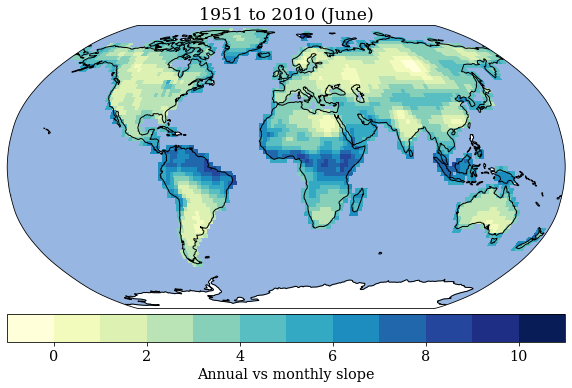

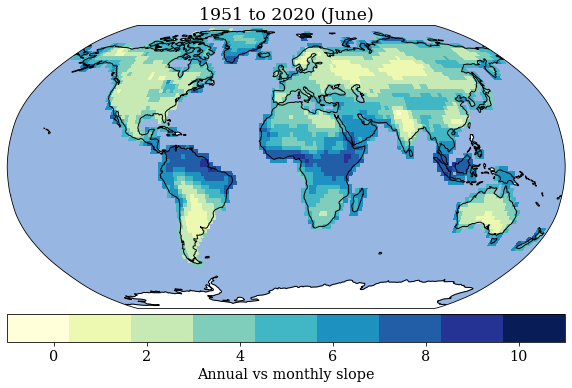

In [209]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
ax.set_title("1951 to 2010 (June)")
cmap = plt.cm.get_cmap('YlGnBu',12)
mesh_1=ax.pcolormesh(lon_pc, lat_pc, trend_2010[ref], cmap=cmap,vmin=-1.0,vmax=11, transform=ccrs.PlateCarree(),rasterized=True)
ax.coastlines()
ax.add_feature(cfeature.OCEAN)
plt.colorbar(mesh_1,orientation='horizontal',label='Annual vs monthly slope', pad=0.01)
plt.show()


fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1,projection=ccrs.Robinson(central_longitude=0))
ax.set_title("1951 to 2020 (June)")
cmap = plt.cm.get_cmap('YlGnBu',9)
mesh_1=ax.pcolormesh(lon_pc, lat_pc, trend_2020[ref], cmap=cmap,vmin=-1.0,vmax=11, transform=ccrs.PlateCarree(),rasterized=True)
ax.coastlines()
ax.add_feature(cfeature.OCEAN)
plt.colorbar(mesh_1,orientation='horizontal',label='Annual vs monthly slope', pad=0.01)
plt.show()